In [4]:
from copy import deepcopy
from typing import List
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn import datasets
from sklearn import tree
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import _check_sample_weight, check_is_fitted

from scipy.special import softmax

from imodels.tree.viz_utils import extract_sklearn_tree_from_figs
#from imodels.util.arguments import check_fit_arguments
#from imodels.util.data_util import encode_categories

def encode_categories(X, features, encoder=None):
    columns_to_keep = list(set(X.columns).difference(features))
    X_encoded = X.loc[:, columns_to_keep]
    X_cat = pd.DataFrame({f: X.loc[:, f] for f in features})
    if encoder is None:
        one_hot_encoder = OneHotEncoder(categories="auto", sparse_output=False)
        X_one_hot = pd.DataFrame(one_hot_encoder.fit_transform(X_cat))
    else:
        one_hot_encoder = encoder
        X_one_hot = pd.DataFrame(one_hot_encoder.transform(X_cat))
    X_one_hot.columns = one_hot_encoder.get_feature_names_out(features)
    X_encoded = pd.concat([X_encoded, X_one_hot], axis=1)
    if encoder is not None:
        return X_encoded
    return X_encoded, one_hot_encoder

import scipy.sparse
from sklearn.utils.validation import check_X_y, check_array
from sklearn.utils.multiclass import check_classification_targets, type_of_target
from sklearn.preprocessing import OneHotEncoder


def check_fit_arguments(model, X, y, feature_names, multi_output=False, is_classmixin=True):
    """Process arguments for fit and predict methods.
    """
    if isinstance(model, ClassifierMixin) and is_classmixin:
        model.classes_, y = np.unique(y, return_inverse=True)  # deals with str inputs
        check_classification_targets(y)

    if feature_names is None:
        if isinstance(X, pd.DataFrame):
            model.feature_names_ = X.columns
        elif isinstance(X, list):
            model.feature_names_ = ['X' + str(i) for i in range(len(X[0]))]
        else:
            model.feature_names_ = ['X' + str(i) for i in range(X.shape[1])]
    else:
        model.feature_names_ = feature_names
    if scipy.sparse.issparse(X):
        X = X.toarray()
    X, y = check_X_y(X=X, y=y, multi_output=multi_output)
    _, model.n_features_in_ = X.shape
    assert len(model.feature_names_) == model.n_features_in_, 'feature_names should be same size as X.shape[1]'
    y = y.astype(float)
    return X, y, model.feature_names_



class Node:
    def __init__(
        self,
        feature: int = None,
        threshold: int = None,
        value=None,
        value_sklearn=None,
        idxs=None,
        is_root: bool = False,
        left=None,
        impurity: float = None,
        impurity_reduction: float = None,
        tree_num: int = None,
        node_id: int = None,
        right=None,
        depth=None,
    ):
        """Node class for splitting"""

        # split or linear
        self.is_root = is_root
        self.idxs = idxs
        self.tree_num = tree_num
        self.node_id = None
        self.feature = feature
        self.impurity = impurity
        self.impurity_reduction = impurity_reduction
        self.value_sklearn = value_sklearn

        # different meanings
        self.value = value # for split this is mean, for linear thifs is weight
        if isinstance(self.value, np.ndarray):
            self.value = self.value.reshape(-1, )

        # split-specific
        self.threshold = threshold
        self.left = left
        self.right = right
        self.left_temp = None
        self.right_temp = None
        #root node has depth 0
        self.depth = depth

    def setattrs(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

    def __str__(self):
        if self.is_root:
            return f"X_{self.feature} <= {self.threshold:0.3f} (Tree #{self.tree_num} root)"
        elif self.left is None and self.right is None:
            return f"Val: {' '.join([str(np.round(i, 3)) for i in self.value])} (leaf)"
        else:
            return f"X_{self.feature} <= {self.threshold:0.3f} (split)"

    def print_root(self, y):
        try:
            one_count = pd.Series(y).value_counts()[1.0]
        except KeyError:
            one_count = 0
        one_proportion = (
            f" {one_count}/{y.shape[0]} ({round(100 * one_count / y.shape[0], 2)}%)"
        )

        if self.is_root:
            return f"X_{self.feature} <= {self.threshold:0.3f}" + one_proportion
        elif self.left is None and self.right is None:
            return f"ΔRisk = {self.value:0.2f}" + one_proportion
        else:
            return f"X_{self.feature} <= {self.threshold:0.3f}" + one_proportion

    def __repr__(self):
        return self.__str__()


class FIGS(BaseEstimator):
    """FIGS (sum of trees) classifier.
    Fast Interpretable Greedy-Tree Sums (FIGS) is an algorithm for fitting concise rule-based models.
    Specifically, FIGS generalizes CART to simultaneously grow a flexible number of trees in a summation.
    The total number of splits across all the trees can be restricted by a pre-specified threshold, keeping the model interpretable.
    Experiments across real-world datasets show that FIGS achieves state-of-the-art prediction performance when restricted to just a few splits (e.g. less than 20).
    https://arxiv.org/abs/2201.11931
    """

    def __init__(
        self,
        max_rules: int = 12,
        max_trees: int = None,
        min_impurity_decrease: float = 0.0,
        random_state=None,
        max_features: str = None,
        max_depth: int = None,
    ):
        """
        Params
        ------
        max_rules: int
            Max total number of rules across all trees
        max_trees: int
            Max total number of trees
        min_impurity_decrease: float
            A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
        max_features
            The number of features to consider when looking for the best split (see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
        """
        super().__init__()
        self.max_rules = max_rules
        self.max_trees = max_trees
        self.min_impurity_decrease = min_impurity_decrease
        self.random_state = random_state
        self.max_features = max_features
        self.max_depth = max_depth
        self._init_decision_function()
        self.n_outputs = None
        self.need_to_reshape = False

    def _init_decision_function(self):
        """Sets decision function based on _estimator_type"""
        # used by sklearn GridSearchCV, BaggingClassifier
        if isinstance(self, ClassifierMixin):

            def decision_function(x):
                return self.predict_proba(x)[:, 1]

        elif isinstance(self, RegressorMixin):
            decision_function = self.predict

    def _construct_node_with_stump(
        self,
        X,
        y,
        idxs,
        tree_num,
        sample_weight=None,
        compare_nodes_with_sample_weight=True,
        max_features=None,
        depth=None,
    ):
        """
        Params
        ------
        compare_nodes_with_sample_weight: Deprecated
            If this is set to true and sample_weight is passed, use sample_weight to compare nodes
            Otherwise, use sample_weight only for picking a split given a particular node
        """

        # array indices
        SPLIT = 0
        LEFT = 1
        RIGHT = 2

        # fit stump
        stump = tree.DecisionTreeRegressor(
            max_depth=1, max_features=max_features)
        sweight = None
        if sample_weight is not None:
            sweight = sample_weight[idxs]
        stump.fit(X[idxs], y[idxs], sample_weight=sweight)

        # these are all arrays, arr[0] is split node
        # note: -2 is dummy
        feature = stump.tree_.feature
        threshold = stump.tree_.threshold

        impurity = stump.tree_.impurity
        n_node_samples = stump.tree_.n_node_samples
        value = stump.tree_.value

        # no split
        if len(feature) == 1:
            # print('no split found!', idxs.sum(), impurity, feature)
            return Node(
                idxs=idxs,
                value=value[SPLIT],
                tree_num=tree_num,
                feature=feature[SPLIT],
                threshold=threshold[SPLIT],
                impurity=impurity[SPLIT],
                impurity_reduction=None,
                depth=depth,
            )

        # manage sample weights
        idxs_split = X[:, feature[SPLIT]] <= threshold[SPLIT]
        idxs_left = idxs_split & idxs
        idxs_right = ~idxs_split & idxs
        if sample_weight is None:
            n_node_samples_left = n_node_samples[LEFT]
            n_node_samples_right = n_node_samples[RIGHT]
        else:
            n_node_samples_left = sample_weight[idxs_left].sum()
            n_node_samples_right = sample_weight[idxs_right].sum()
        n_node_samples_split = n_node_samples_left + n_node_samples_right

        # calculate impurity
        impurity_reduction = (
            impurity[SPLIT]
            - impurity[LEFT] * n_node_samples_left / n_node_samples_split
            - impurity[RIGHT] * n_node_samples_right / n_node_samples_split
        ) * n_node_samples_split

        node_split = Node(
            idxs=idxs,
            value=value[SPLIT],
            tree_num=tree_num,
            feature=feature[SPLIT],
            threshold=threshold[SPLIT],
            impurity=impurity[SPLIT],
            impurity_reduction=impurity_reduction,
            depth=depth,
        )
        # print('\t>>>', node_split, 'impurity', impurity, 'num_pts', idxs.sum(), 'imp_reduc', impurity_reduction)

        # manage children
        node_left = Node(
            idxs=idxs_left,
            value=value[LEFT],
            impurity=impurity[LEFT],
            tree_num=tree_num,
            depth=depth+1,
        )
        node_right = Node(
            idxs=idxs_right,
            value=value[RIGHT],
            impurity=impurity[RIGHT],
            tree_num=tree_num,
            depth=depth+1,
        )
        node_split.setattrs(
            left_temp=node_left,
            right_temp=node_right,
        )
        return node_split

    def _encode_categories(self, X, categorical_features):
        encoder = None
        if hasattr(self, "_encoder"):
            encoder = self._encoder
        return encode_categories(X, categorical_features, encoder)

    def fit(
        self,
        X,
        y=None,
        feature_names=None,
        verbose=False,
        sample_weight=None,
        categorical_features=None,
    ):
        """
        Params
        ------
        _sample_weight: array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
            Splits that would create child nodes with net zero or negative weight
            are ignored while searching for a split in each node.
        """
        if categorical_features is not None:
            X, self._encoder = self._encode_categories(X, categorical_features)
            
        if hasattr(y, 'values'):
            y = y.values
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        if isinstance(self, ClassifierMixin):
            assert y.shape[1] == 1, "FIGSClassifier requires a 1-dimensional input"
            if hasattr(y, 'name'):
                class_name = y.name
            elif hasattr(y, 'columns'):
                class_name = y.columns[0]
            else:
                class_name = 'class'

            #self.classes_, y = np.unique(y, return_inverse=True)
            self.classes_ = np.unique(y)

            y, self._class_encoder = self._encode_categories(pd.DataFrame(y, columns = [class_name]), [class_name])
            self.Y = y
            self._class_map = {i:c for i, c in zip(np.arange(0, y.shape[1]), self._class_encoder.inverse_transform(np.eye(y.shape[1])).reshape(-1, ))}
            
        X, y, feature_names = check_fit_arguments(self, X, y, feature_names, True, False)
        self.Y = y
        self.n_outputs = y.shape[1]
        self.n_features = X.shape[1]
        
        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X)
            
        self.trees_ = []  # list of the root nodes of added trees
        self.complexity_ = 0  # tracks the number of rules in the model
        y_predictions_per_tree = {}  # predictions for each tree
        y_residuals_per_tree = {}  # based on predictions above

        # set up initial potential_splits
        # everything in potential_splits either is_root (so it can be added directly to self.trees_)
        # or it is a child of a root node that has already been added
        idxs = np.ones(X.shape[0], dtype=bool)
        node_init = self._construct_node_with_stump(
            X=X,
            y=y,
            idxs=idxs,
            tree_num=-1,
            sample_weight=sample_weight,
            max_features=self.max_features,
            depth=0,
        )
        potential_splits = [node_init]
        for node in potential_splits:
            node.setattrs(is_root=True)
        potential_splits = sorted(
            potential_splits, key=lambda x: x.impurity_reduction)

        # start the greedy fitting algorithm
        finished = False
        while len(potential_splits) > 0 and not finished:
            # print('potential_splits', [str(s) for s in potential_splits])
            # get node with max impurity_reduction (since it's sorted)
            split_node = potential_splits.pop()

            # don't split on node
            if split_node.impurity_reduction < self.min_impurity_decrease:
                finished = True
                break
            elif (
                split_node.is_root
                and self.max_trees is not None
                and len(self.trees_) >= self.max_trees
            ):
                # If the node is the root of a new tree and we have reached self.max_trees,
                # don't split on it, but allow later splits to continue growing existing trees
                continue
            elif (
                self.max_depth is not None
                and split_node.depth > self.max_depth
            ):
                # If the node is deeper than self.max_depth,
                # don't split on it, but allow algorithm to continue
                continue

            # split on node
            if verbose:
                print("\nadding " + str(split_node))
            self.complexity_ += 1

            # if added a tree root
            if split_node.is_root:
                # start a new tree
                self.trees_.append(split_node)

                # update tree_num
                for node_ in [split_node, split_node.left_temp, split_node.right_temp]:
                    if node_ is not None:
                        node_.tree_num = len(self.trees_) - 1

                # add new root potential node
                node_new_root = Node(
                    is_root=True, idxs=np.ones(X.shape[0], dtype=bool), tree_num=-1, depth=0,
                )
                potential_splits.append(node_new_root)

            # add children to potential splits
            # assign left_temp, right_temp to be proper children
            # (basically adds them to tree in predict method)
            split_node.setattrs(left=split_node.left_temp,
                                right=split_node.right_temp)

            # add children to potential_splits
            potential_splits.append(split_node.left)
            potential_splits.append(split_node.right)

            # update predictions for altered tree
            for tree_num_ in range(len(self.trees_)):
                y_predictions_per_tree[tree_num_] = self._predict_tree(
                    self.trees_[tree_num_], X
                )
            # dummy 0 preds for possible new trees
            y_predictions_per_tree[-1] = np.zeros((X.shape[0], self.n_outputs))

            # update residuals for each tree
            # -1 is key for potential new tree
            for tree_num_ in list(range(len(self.trees_))) + [-1]:
                y_residuals_per_tree[tree_num_] = deepcopy(y)

                # subtract predictions of all other trees
                # Since the current tree makes a constant prediction over the node being split,
                # one may ignore its contributions to the residuals without affecting the impurity decrease.
                for tree_num_other_ in range(len(self.trees_)):
                    if not tree_num_other_ == tree_num_:
                        y_residuals_per_tree[tree_num_] -= y_predictions_per_tree[
                            tree_num_other_
                        ]

            # recompute all impurities + update potential_split children
            potential_splits_new = []
            for potential_split in potential_splits:
                y_target = y_residuals_per_tree[potential_split.tree_num]

                # re-calculate the best split
                potential_split_updated = self._construct_node_with_stump(
                    X=X,
                    y=y_target,
                    idxs=potential_split.idxs,
                    tree_num=potential_split.tree_num,
                    sample_weight=sample_weight,
                    max_features=self.max_features,
                    depth=potential_split.depth+1,
                )

                # need to preserve certain attributes from before (value at this split + is_root)
                # value may change because residuals may have changed, but we want it to store the value from before
                potential_split.setattrs(
                    feature=potential_split_updated.feature,
                    threshold=potential_split_updated.threshold,
                    impurity_reduction=potential_split_updated.impurity_reduction,
                    impurity=potential_split_updated.impurity,
                    left_temp=potential_split_updated.left_temp,
                    right_temp=potential_split_updated.right_temp,
                )

                # this is a valid split
                if potential_split.impurity_reduction is not None:
                    potential_splits_new.append(potential_split)

            # sort so largest impurity reduction comes last (should probs make this a heap later)
            potential_splits = sorted(
                potential_splits_new, key=lambda x: x.impurity_reduction
            )
            if verbose:
                print(self)
            if self.max_rules is not None and self.complexity_ >= self.max_rules:
                finished = True
                break

        # annotate final tree with node_id and value_sklearn, and prepare importance_data_
        importance_data = []
        for tree_ in self.trees_:
            node_counter = iter(range(0, int(1e06)))

            def _annotate_node(node: Node, X, y, is_classmixin=False):
                #TODO: impurity decrease is correct
                if node is None:
                    return

                # TODO does not incorporate sample weights
                #TODO: how to handdle for n_outputs> 1?
                if is_classmixin:
                    unique, counts = np.unique(np.argmax(y, axis = 1), return_counts=True)
                    
                    value_sklearn = np.zeros(self.n_outputs)
                    value_sklearn[unique] = counts
                    value_sklearn = value_sklearn.astype(float)
                
                else:
                    value_sklearn = np.array([X.shape[0]], dtype=float)

                node.setattrs(node_id=next(node_counter),
                              value_sklearn=value_sklearn)

                idxs_left = X[:, node.feature] <= node.threshold
                _annotate_node(node.left, X[idxs_left], y[idxs_left], is_classmixin)
                _annotate_node(node.right, X[~idxs_left], y[~idxs_left], is_classmixin)
            
            _annotate_node(tree_, X, y, isinstance(self, ClassifierMixin))

            # now that the samples per node are known, we can start to compute the importances
            importance_data_tree = np.zeros(self.n_features)

            def _importances(node: Node):
                if node is None or node.left is None:
                    return 0.0

                # TODO does not incorporate sample weights, but will if added to value_sklearn
                importance_data_tree[node.feature] += (
                    np.sum(node.value_sklearn) * node.impurity
                    - np.sum(node.left.value_sklearn) * node.left.impurity
                    - np.sum(node.right.value_sklearn) * node.right.impurity
                )

                return (
                    np.sum(node.value_sklearn)
                    + _importances(node.left)
                    + _importances(node.right)
                )

            # require the tree to have more than 1 node, otherwise just leave importance_data_tree as zeros
            if 1 < next(node_counter):
                tree_samples = _importances(tree_)
                if tree_samples != 0:
                    importance_data_tree /= tree_samples
                else:
                    importance_data_tree = 0

            importance_data.append(importance_data_tree)

        self.importance_data_ = importance_data
        
        return self

    def _tree_to_str(self, root: Node, prefix=""):
        if root is None:
            return ""
        elif root.threshold is None:
            return ""
        pprefix = prefix + "\t"
        return (
            prefix
            + str(root)
            + "\n"
            + self._tree_to_str(root.left, pprefix)
            + self._tree_to_str(root.right, pprefix)
        )

    def _tree_to_str_with_data(self, X, y, root: Node, prefix=""):
        if root is None:
            return ""
        elif root.threshold is None:
            return ""
        pprefix = prefix + "\t"
        left = X[:, root.feature] <= root.threshold
        return (
            prefix
            + root.print_root(y)
            + "\n"
            + self._tree_to_str_with_data(X[left], y[left], root.left, pprefix)
            + self._tree_to_str_with_data(X[~left],
                                          y[~left], root.right, pprefix)
        )

    def __str__(self):
        if not hasattr(self, "trees_"):
            s = self.__class__.__name__
            s += "("
            s += "max_rules="
            s += repr(self.max_rules)
            s += ", "
            s += "max_trees="
            s += repr(self.max_trees)
            s += ", "
            s += "max_depth="
            s += repr(self.max_depth)
            s += ")"
            return s
        else:
            s = "> ------------------------------\n"
            s += "> FIGS-Fast Interpretable Greedy-Tree Sums:\n"
            s += '> \tPredictions are made by summing the "Val" reached by traversing each tree.\n'
            s += "> \tFor classifiers, a softmax function is then applied to the sum.\n"
            s += "> ------------------------------\n"
            s += "\n\t+\n".join([self._tree_to_str(t) for t in self.trees_])
            if hasattr(self, "feature_names_") and self.feature_names_ is not None:
                for i in range(len(self.feature_names_))[::-1]:
                    s = s.replace(f"X_{i}", self.feature_names_[i])
            return s

    def print_tree(self, X, y, feature_names=None):
        s = "------------\n" + "\n\t+\n".join(
            [self._tree_to_str_with_data(X, y, t) for t in self.trees_]
        )
        if feature_names is None:
            if hasattr(self, "feature_names_") and self.feature_names_ is not None:
                feature_names = self.feature_names_
        if feature_names is not None:
            for i in range(len(feature_names))[::-1]:
                s = s.replace(f"X_{i}", feature_names[i])
        return s

    def predict(self, X, categorical_features=None, by_tree=False):
        if hasattr(self, "_encoder"):
            X = self._encode_categories(
                X, categorical_features=categorical_features)
        X = check_array(X)
        preds = np.zeros((X.shape[0], self.n_outputs, len(self.trees_)))
        for i, tree in enumerate(self.trees_):
            preds[:, :, i] += self._predict_tree(tree, X)
        
        if isinstance(self, RegressorMixin):
            if by_tree:
                return preds
            else:
                if self.n_outputs==1:
                    return np.sum(preds, axis = -1).reshape(-1, )
                return np.sum(preds, axis = -1)
        elif isinstance(self, ClassifierMixin):
            if by_tree:
                return preds
            else:
                preds = np.sum(preds, axis = -1)
                max_indices = np.argmax(preds, axis = 1)

                return np.vectorize(self._class_map.get)(max_indices)

            #TODO: account for non integer classes, FYI self.classes_ comes from check_arguments
#             class_preds = (preds > 0.5).astype(int)
#             return np.array([self.classes_[i] for i in class_preds])

    def predict_proba(self, X, categorical_features=None, use_clipped_prediction=False):
        """Predict probability for classifiers:
        Default behavior is to constrain the outputs to the range of probabilities, i.e. 0 to 1, with a sigmoid function.
        Set use_clipped_prediction=True to use prior behavior of clipping between 0 and 1 instead.
        """
        if hasattr(self, "_encoder"):
            X = self._encode_categories(
                X, categorical_features=categorical_features)
        X = check_array(X)
        if isinstance(self, RegressorMixin):
            return NotImplemented
        preds = np.zeros((X.shape[0], self.n_outputs))
        for tree in self.trees_:
            preds += self._predict_tree(tree, X)
        if use_clipped_prediction:
            # old behavior, pre v1.3.9
            # constrain to range of probabilities by clipping
            return np.clip(preds, a_min=0.0, a_max=1.0)
        else:
            # constrain to range of probabilities with a softmax (multi-class) or a sigmoid (binary) function
            return softmax(preds, axis = 1)


    def _predict_tree(self, root: Node, X):
        """Predict for a single tree"""

        def _predict_tree_single_point(root: Node, x):
            if root.left is None and root.right is None:
                return root.value
            left = x[root.feature] <= root.threshold
            if left:
                if root.left is None:  # we don't actually have to worry about this case
                    return root.value
                else:
                    return _predict_tree_single_point(root.left, x)
            else:
                if (
                    root.right is None
                ):  # we don't actually have to worry about this case
                    return root.value
                else:
                    return _predict_tree_single_point(root.right, x)

        preds = np.zeros((X.shape[0], self.n_outputs))
        for i in range(X.shape[0]):
            preds[i] = _predict_tree_single_point(root, X[i])
        return preds

    @property
    def feature_importances_(self):
        """Gini impurity-based feature importances"""
        check_is_fitted(self)

        avg_feature_importances = np.mean(
            self.importance_data_, axis=0, dtype=np.float64
        )

        return avg_feature_importances / np.sum(avg_feature_importances)

    def plot(
        self,
        cols=2,
        feature_names=None,
        filename=None,
        label="all",
        impurity=False,
        tree_number=None,
        dpi=150,
        fig_size=None,
    ):
        is_single_tree = len(self.trees_) < 2 or tree_number is not None
        n_cols = int(cols)
        n_rows = int(np.ceil(len(self.trees_) / n_cols))

        if feature_names is None:
            if hasattr(self, "feature_names_") and self.feature_names_ is not None:
                feature_names = self.feature_names_

        n_plots = int(len(self.trees_)) if tree_number is None else 1
        fig, axs = plt.subplots(n_plots, dpi=dpi)
        if fig_size is not None:
            fig.set_size_inches(fig_size, fig_size)

        n_classes = 1 if isinstance(self, RegressorMixin) else self.n_outputs
        ax_size = int(len(self.trees_))
        for i in range(n_plots):
            r = i // n_cols
            c = i % n_cols
            if not is_single_tree:
                ax = axs[i]
            else:
                ax = axs
            try:
                dt = extract_sklearn_tree_from_figs(
                    self, i if tree_number is None else tree_number, n_classes
                )
                plot_tree(
                    dt,
                    ax=ax,
                    feature_names=feature_names,
                    label=label,
                    impurity=impurity,
                )
            except IndexError:
                ax.axis("off")
                continue
            ttl = f"Tree {i}" if n_plots > 1 else f"Tree {tree_number}"
            ax.set_title(ttl)
        if filename is not None:
            plt.savefig(filename)
            return
        plt.show()


class FIGSRegressor(FIGS, RegressorMixin):
    ...


class FIGSClassifier(FIGS, ClassifierMixin):
    
    @property
    def class_map(self):
        return self._class_map


class FIGSCV:
    def __init__(
        self,
        figs,
        n_rules_list: List[int] = [6, 12, 24, 30, 50],
        n_trees_list: List[int] = [5, 10, 15],
        depth_list: List[int] = [3, 4],
        min_impurity_decrease_list: List[float] = [0],
        cv: int = 3,
        scoring=None,
        *args,
        **kwargs,
    ):

        self._figs_class = figs
        self.n_rules_list = np.array(n_rules_list)
        self.n_trees_list = np.array(n_trees_list)
        self.depth_list = np.array(depth_list)
        self.min_impurity_decrease_list = np.array(min_impurity_decrease_list)
        self.cv = cv
        self.scoring = scoring

    def fit(self, X, y):
        self.scores_ = []
        for _i, (n_rules, n_trees, depth, min_impurity_decrease) in enumerate(itertools.product(*[self.n_rules_list, self.n_trees_list, self.depth_list, self.min_impurity_decrease_list])):
            est = self._figs_class(max_rules=n_rules, max_trees=n_trees, max_depth=depth, min_impurity_decrease=min_impurity_decrease)
            cv_scores = cross_val_score(est, X, y, cv=self.cv, scoring=self.scoring)
            mean_score = np.mean(cv_scores)
            if len(self.scores_) == 0:
                self.figs = est
            elif mean_score > np.max(self.scores_):
                self.figs = est

            self.scores_.append(mean_score)
        self.figs.fit(X=X, y=y)

    def predict_proba(self, X):
        return self.figs.predict_proba(X)

    def predict(self, X, by_tree = False):
        return self.figs.predict(X, by_tree = by_tree)

    @property
    def max_rules(self):
        return self.figs.max_rules

    @property
    def max_trees(self):
        return self.figs.max_trees
    
    @property
    def max_depth(self):
        return self.figs.max_depth
    
    @property
    def min_impurity_decrease(self):
        return self.figs.min_impurity_decrease
    
    @property
    def trees_(self):
        return self.figs.trees_


class FIGSRegressorCV(FIGSCV):
    def __init__(
        self,
        n_rules_list: List[int] = [6, 12, 24, 30, 50],
        n_trees_list: List[int] = [5, 10, 15],
        depth_list: List[int] = [3, 4],
        min_impurity_decrease_list: List[float] = [0],
        cv: int = 3,
        scoring="r2",
        *args,
        **kwargs,
    ):
        super(FIGSRegressorCV, self).__init__(
            figs=FIGSRegressor,
            n_rules_list=n_rules_list,
            n_trees_list=n_trees_list,
            depth_list=depth_list,
            min_impurity_decrease_list=min_impurity_decrease_list,
            cv=cv,
            scoring=scoring,
            *args,
            **kwargs,
        )


#TODO: handle annoying CV errors
class FIGSClassifierCV(FIGSCV):
    def __init__(
        self,
        n_rules_list: List[int] = [6, 12, 24, 30, 50],
        n_trees_list: List[int] = [5, 10, 15],
        depth_list: List[int] = [3, 4],
        min_impurity_decrease_list: List[float] = [0],
        cv: int = 3,
        scoring="accuracy",
        *args,
        **kwargs,
    ):
        super(FIGSClassifierCV, self).__init__(
            figs=FIGSClassifier,
            n_rules_list=n_rules_list,
            n_trees_list=n_trees_list,
            depth_list=depth_list,
            min_impurity_decrease_list=min_impurity_decrease_list,
            cv=cv,
            scoring=scoring,
            *args,
            **kwargs,
        )
        

        
# class FIGSHydraRegressor():
#     def __init__(
#         self,
#         max_rules: int = 12,
#         max_trees: int = None,
#         min_impurity_decrease: float = 0.0,
#         random_state=None,
#         max_features: str = None,
#         max_depth: int = None
#     ):
        
#         self.max_rules = max_rules
#         self.max_trees = max_trees
#         self.min_impurity_decrease = min_impurity_decrease
#         self.random_state = random_state
#         self.max_features = max_features
#         self.max_depth = max_depth
#         self.estimators = []
        
#     def fit(self, X, y):
#         if isinstance(y, pd.DataFrame):
#             y = y.to_numpy()
#         for i in range(y.shape[1]):
#             est = FIGSRegressor(max_rules=self.max_rules, max_trees=self.max_trees, max_depth=self.max_depth)
#             est.fit(X, y[:, i].reshape(-1, 1))
#             self.estimators.append(est)
    
#     def predict(self, X):
#         return np.array([est.predict(X) for est in self.estimators]).T.squeeze(0)

        


In [5]:
est = FIGSRegressor(max_rules=10)
est.fit(X_cat, pd.Series(Y_cat), categorical_features=["pet1", "pet2"])
#est.fit(X_cat, X_cat.drop(columns=["pet1", "pet2"]), categorical_features=["pet1", "pet2"])
print(est.predict(X_cat, categorical_features=["pet1", "pet2"]).shape)
#est.plot(tree_number=1)
print(est.n_outputs)

(100,)
1


In [7]:
from sklearn.metrics import accuracy_score

In [ ]:
est.feature_importances_

In [ ]:
X_cls.shape

In [8]:
est = FIGSClassifier(max_rules=10)
# est.fit(X_cls, Y_cls, sample_weight=np.arange(0, X_cls.shape[0]))
est.fit(X_cls, pd.Series(Y_cls).map({0:'cat', 1:'dog'}), sample_weight=[1] * X_cls.shape[0])
print(accuracy_score(est.predict(X_cls), pd.Series(Y_cls).map({0:'cat', 1:'dog'})))
est.predict_proba(X_cls, use_clipped_prediction=True)

0.9876977152899824


array([[1.        , 0.        ],
       [0.99418605, 0.00581395],
       [0.99418605, 0.00581395],
       ...,
       [0.99418605, 0.00581395],
       [0.99418605, 0.00581395],
       [0.01204819, 0.98795181]])

In [ ]:
est.trees_[0].value_sklearn

In [ ]:
sum(est.trees_[0].left.value_sklearn)

In [ ]:
sum(est.trees_[0].right.value_sklearn)

In [ ]:
unique, counts = np.unique(np.argmax(np.eye(4), axis = 1), return_counts=True)
unique, counts

In [ ]:
est.trees_

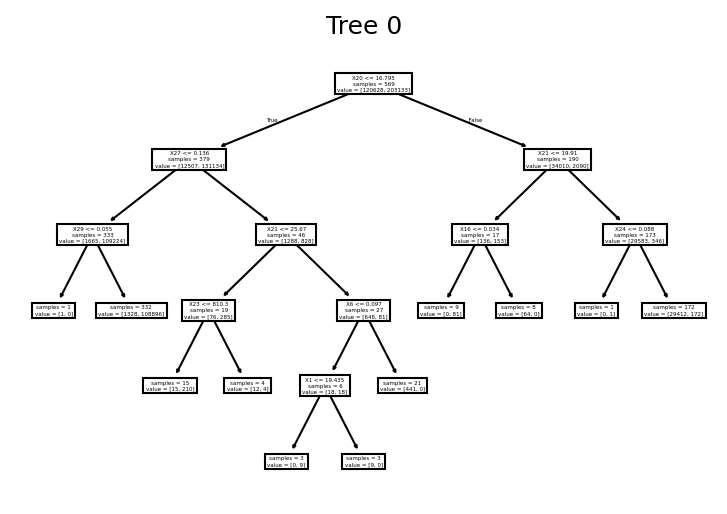

In [9]:
est.plot(tree_number=0)

In [ ]:
np.unique(np.array(['goat','cat', 'dog', 'sheep', 'cat']).reshape(-1, 1), return_inverse=True)

(100,)


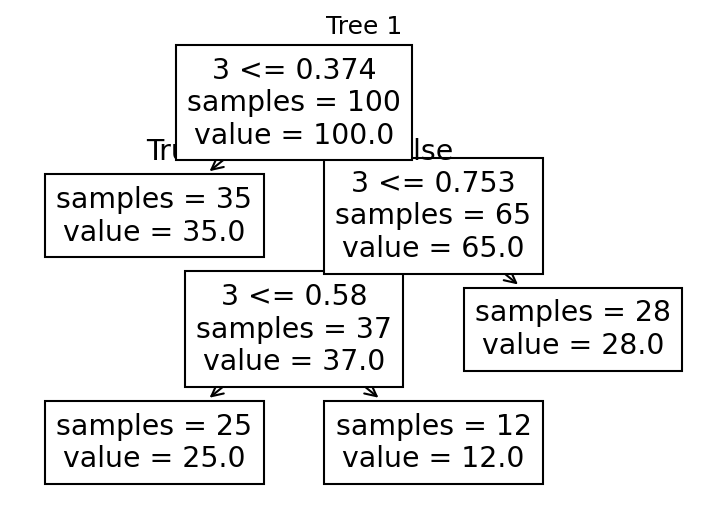

30


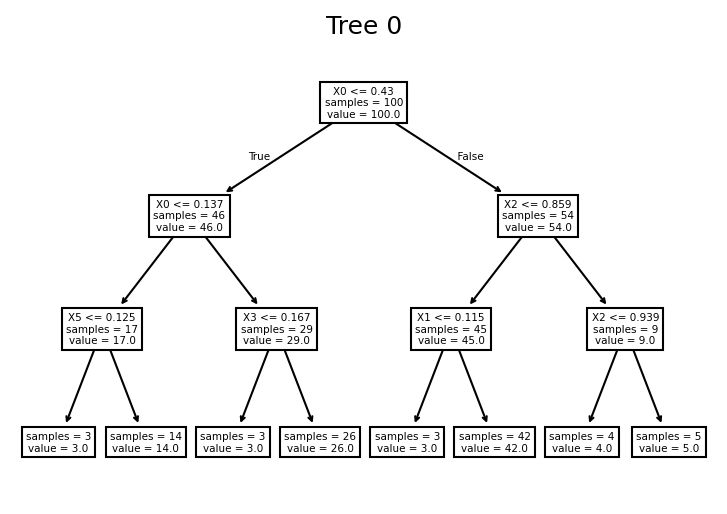

12


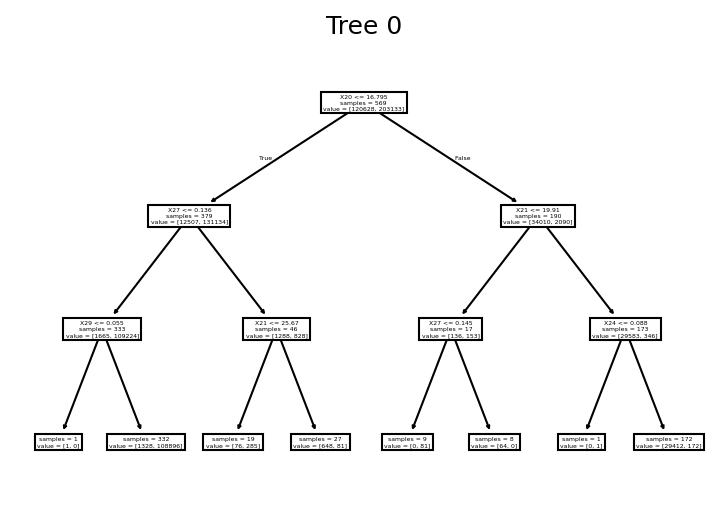

In [3]:
from sklearn import datasets

X_cls, Y_cls = datasets.load_breast_cancer(return_X_y=True)
X_reg, Y_reg = datasets.make_friedman1(100)

categories = ["cat", "dog", "bird", "fish"]
categories_2 = ["bear", "chicken", "cow"]

X_cat = pd.DataFrame(X_reg)
X_cat["pet1"] = np.random.choice(categories, size=(100, 1))
X_cat["pet2"] = np.random.choice(categories_2, size=(100, 1))

# X_cat.columns[-1] = "pet"
Y_cat = Y_reg

est = FIGSRegressor(max_rules=10)
est.fit(X_cat, Y_cat, categorical_features=["pet1", "pet2"])
print(est.predict(X_cat, categorical_features=["pet1", "pet2"]).shape)
est.plot(tree_number=1)

est = FIGSClassifier(max_rules=10)
# est.fit(X_cls, Y_cls, sample_weight=np.arange(0, X_cls.shape[0]))
est.fit(X_cls, Y_cls, sample_weight=[1] * X_cls.shape[0])
est.predict(X_cls)

est = FIGSRegressorCV()
est.fit(X_reg, Y_reg)
est.predict(X_reg)
print(est.max_rules)
est.figs.plot(tree_number=0)

est = FIGSClassifierCV()
est.fit(X_cls, Y_cls)
est.predict(X_cls)
print(est.max_rules)
est.figs.plot(tree_number=0)


In [ ]:
from imodels_figs import FIGSRegressor as iFIGSRegressor

In [ ]:
esti = iFIGSRegressor(max_rules=10)
esti.fit(X_cat, Y_cat, categorical_features=["pet1", "pet2"])

In [ ]:
esti.predict(X_cat, categorical_features=["pet1", "pet2"]).shape

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_cls, pd.Series(Y_cls).map({0:'cat', 1:'dog'}))

In [ ]:
Y_cls

In [ ]:
dt.classes_

In [ ]:
from sklearn import datasets

X_cls, Y_cls = datasets.load_breast_cancer(return_X_y=True)
X_reg, Y_reg = datasets.make_friedman1(100)

categories = ["cat", "dog", "bird", "fish"]
categories_2 = ["bear", "chicken", "cow"]

X_cat = pd.DataFrame(X_reg)
X_cat["pet1"] = np.random.choice(categories, size=(100, 1))
X_cat["pet2"] = np.random.choice(categories_2, size=(100, 1))

# X_cat.columns[-1] = "pet"
Y_cat = Y_reg

est = iFIGSRegressor(max_rules=10)
est.fit(X_cat, Y_cat, categorical_features=["pet1", "pet2"])
est.predict(X_cat, categorical_features=["pet1", "pet2"])
est.plot(tree_number=1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit_transform(pd.DataFrame(Y_cls))

In [ ]:
t_s = pd.Series(Y_cls, name = 'target')

In [ ]:
t_d = pd.DataFrame(Y_cls, columns = ['hello'])

In [ ]:
hasattr(Y_cls, 'values')

In [ ]:
from imodels_figs import FIGSClassifier as iFIGSClassifier
est = iFIGSClassifier(max_rules=10)
# est.fit(X_cls, Y_cls, sample_weight=np.arange(0, X_cls.shape[0]))
est.fit(X_cls, pd.DataFrame(Y_cls), sample_weight=[1] * X_cls.shape[0])
est.predict(X_cls)


In [ ]:
est.plot(tree_number=0)

In [ ]:
from imodels_figs import FIGSClassifierCV as iFIGSClassifierCV
from imodels_figs import FIGSRegressorCV as iFIGSRegressorCV

est = iFIGSRegressorCV()
est.fit(X_reg, Y_reg)
est.predict(X_reg)
print(est.max_rules)
est.figs.plot(tree_number=0)

est = iFIGSClassifierCV()
est.fit(X_cls, Y_cls)
est.predict(X_cls)
print(est.max_rules)
est.figs.plot(tree_number=0)